In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

# Prepare mouse data

In [ ]:
# Load imputed MERFISH mouse section 50 data (https://alleninstitute.github.io/abc_atlas_access/descriptions/MERFISH-C57BL6J-638850-imputed.html)
s50 = sc.read_h5ad('../../../../Data/MERFISH-C57BL6J/MERFISH-C57BL6J-imputed-section50-modules-consolidated.h5ad')
s50

AnnData object with n_obs × n_vars = 45611 × 8456
    obs: 'brain_section_label', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_reconstructed', 'y_reconstructed', 'z_reconstructed', 'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'bg_mask', 'modules', 'module_name', 'section'
    var: 'ensembl_id'
    uns: 'module_name_colors', 'parcellation_division_colors', 'parcellation_structure_colors', 'parcellation_substructure_colors'
    obsm: 'X_

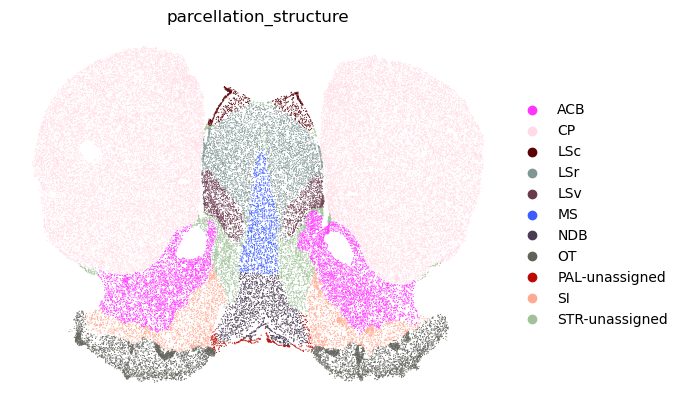

In [3]:
sc.pl.embedding(s50, basis='X_spatial', color='parcellation_structure', mask_obs='bg_mask', frameon=False)

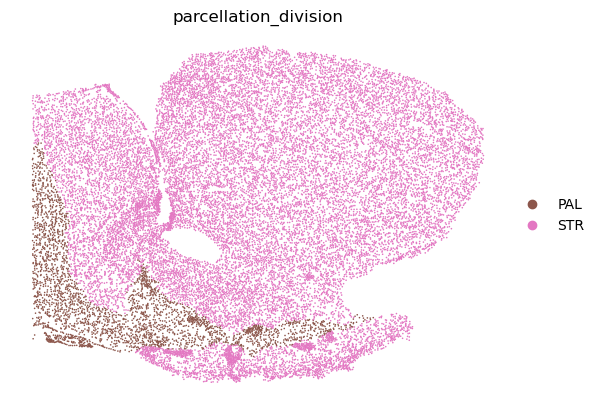

In [4]:
s50_right = s50[(s50.obsm['X_spatial'][:,0] > -5.5)].copy()
sc.pl.embedding(s50_right, basis='X_spatial', color='parcellation_division', mask_obs='bg_mask', frameon=False)

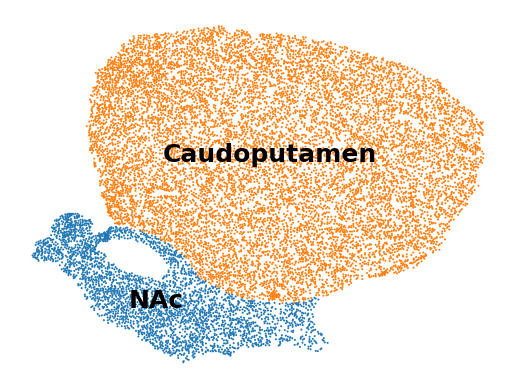

In [5]:
# Filter for basal ganglia structures
str_mask = s50_right.obs['parcellation_structure'].isin(['CP', 'ACB'])
s50_right_str = s50_right[str_mask].copy()

# Create a mapping dictionary for structure names
structure_mapping = {
    'CP': 'Caudoputamen',
    'ACB': 'NAc'
}

# Create new observation column with full structure names
s50_right_str.obs['structure_name'] = s50_right_str.obs['parcellation_structure'].map(structure_mapping)

sc.pl.embedding(s50_right_str, basis='X_spatial', color='structure_name', legend_loc='on data', legend_fontsize=18, title='', frameon=False)

# Prepare human data

In [14]:
# Load human stereo-seq data from chip 3 and 4
chip34 = sc.read_h5ad('../../../../Data/Stereo-seq_human_bg/chip34_adata.h5ad')
chip34

AnnData object with n_obs × n_vars = 1457666 × 72143
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered'
    var: 'Gene'
    obsm: 'cell_border', 'spatial'

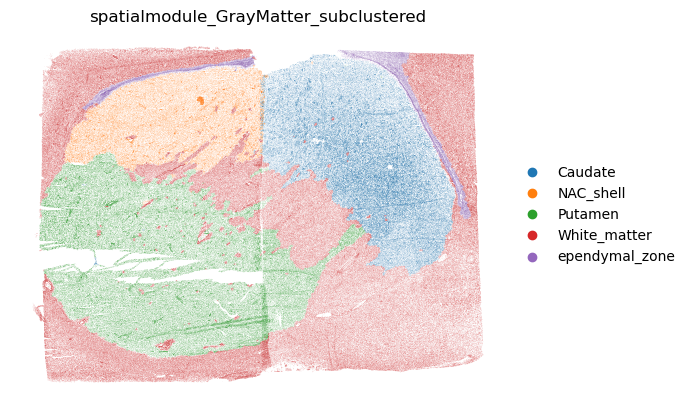

In [15]:
sc.pl.embedding(chip34, basis='spatial', color='spatialmodule_GrayMatter_subclustered', frameon=False)

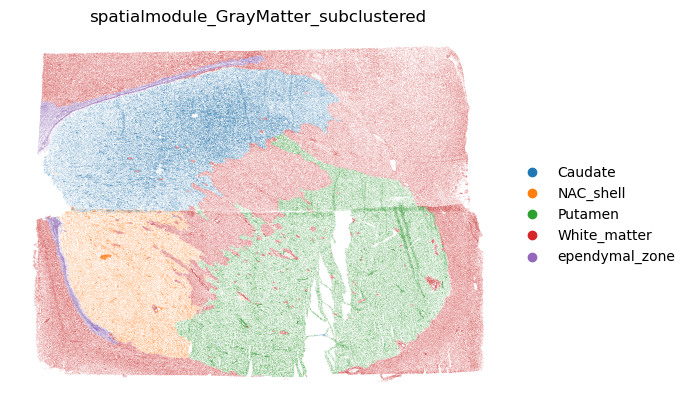

In [16]:
# Rotate chip34 spatial coordinates 
chip34_rot = chip34.copy()
coords = chip34_rot.obsm['spatial'].copy()
center = coords.mean(axis=0)
coords_centered = coords - center
rot90_ccw = np.array([[0, -1],
                      [1,  0]])
coords_rot = coords_centered @ rot90_ccw.T + center
chip34.obsm['spatial'] = coords_rot

sc.pl.embedding(chip34, basis='spatial', color='spatialmodule_GrayMatter_subclustered', frameon=False)

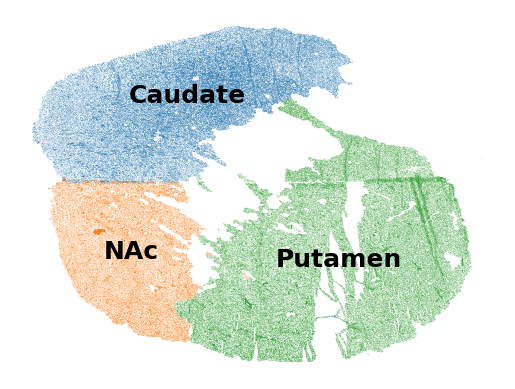

In [17]:
# Filter for basal ganglia structures
anatomical_mask = chip34.obs['spatialmodule_GrayMatter_subclustered'].isin(['Caudate', 'Putamen', 'NAC_shell'])
chip34 = chip34[anatomical_mask].copy()

# Create a mapping dictionary for structure names
structure_mapping = {
    'Caudate': 'Caudate',
    'Putamen': 'Putamen',
    'NAC_shell': 'NAc'
}

# Create new observation column with full structure names
chip34.obs['structure_name'] = chip34.obs['spatialmodule_GrayMatter_subclustered'].map(structure_mapping)

sc.pl.embedding(chip34, basis='spatial', color='structure_name', legend_loc='on data', legend_fontsize=18, title='', frameon=False)

In [18]:
# Switch var_names to gene symbols
chip34.var['ensmbl_id'] = chip34.var_names
chip34.var_names = chip34.var['Gene']
chip34.var

/Users/besser/miniconda3/envs/dumitru2025_re-analysis/lib/python3.11/site-packages/anndata/_core/anndata.py:869: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'FIRRM']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


Gene        ensmbl_id
Gene                                 
TSPAN6        TSPAN6  ENSG00000000003
TNMD            TNMD  ENSG00000000005
DPM1            DPM1  ENSG00000000419
SCYL3          SCYL3  ENSG00000000457
FIRRM          FIRRM  ENSG00000000460
...              ...              ...
LINC03014  LINC03014  ENSG00000310535
LINC03014  LINC03014  ENSG00000310536
PMS2P3        PMS2P3  ENSG00000310537
DDX11L2      DDX11L2  ENSG00000310539
LINC03112  LINC03112  ENSG00000310557

[72143 rows x 2 columns]

In [19]:
# Function to average duplicate genes

import scipy.sparse as sp
from anndata import AnnData

def average_duplicate_genes(adata: AnnData) -> AnnData:
    """
    Collapse duplicate genes in an AnnData by averaging their expression values.
    Keeps metadata from the first occurrence of each gene.
    """

    # Find unique genes and mapping
    unique_genes, inverse_indices = np.unique(adata.var_names, return_inverse=True)

    # Ensure X is CSR sparse for efficient multiplication
    X = adata.X.tocsr() if sp.issparse(adata.X) else adata.X

    # Summing matrix (n_vars → n_unique_genes)
    summing_matrix = sp.csr_matrix(
        (np.ones(adata.n_vars), (np.arange(adata.n_vars), inverse_indices)),
        shape=(adata.n_vars, len(unique_genes))
    )

    # Collapse duplicates (sum then average)
    new_X = X @ summing_matrix
    gene_counts = np.bincount(inverse_indices)
    new_X = new_X @ sp.diags(1.0 / gene_counts)

    # Keep metadata of *first occurrence* of each gene
    first_occurrence = (
        pd.Series(np.arange(len(inverse_indices)), index=adata.var_names)
        .groupby(level=0)
        .first()
    )
    new_var = adata.var.iloc[first_occurrence.values].copy()
    new_var.index = unique_genes

    # Build new AnnData
    adata_new = AnnData(new_X, obs=adata.obs.copy(), var=new_var)

    # Copy metadata
    adata_new.uns = adata.uns.copy()
    adata_new.obsm = adata.obsm.copy()
    adata_new.varm = adata.varm.copy()

    return adata_new

chip34 = average_duplicate_genes(chip34)
chip34

/var/folders/ht/zvss6k9907s_3jznnkbgg0w00000gn/T/ipykernel_3141/2301612377.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(level=0)


AnnData object with n_obs × n_vars = 754607 × 36126
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag', 'Chip', 'x_aligned', 'y_aligned', 'Highlevel_spatialmodule', 'spatialmodule_GrayMatter_subclustered', 'structure_name'
    var: 'Gene', 'ensmbl_id'
    uns: 'spatialmodule_GrayMatter_subclustered_colors', 'structure_name_colors'
    obsm: 'cell_border', 'spatial'

In [ ]:
import matplotlib.pyplot as plt
import os

# Path (set to file you want to create)
save_path = "images/bg_substructures.png"

# Ensure structure_name exists
assert 'structure_name' in chip34.obs.columns
assert 'structure_name' in s50_right_str.obs.columns

# Raw string series
cats1 = chip34.obs['structure_name'].astype(str)
cats2 = s50_right_str.obs['structure_name'].astype(str)

# Desired order of structures
desired_order = [c for c in ['NAc', 'Caudate', 'Putamen', 'Caudoputamen']
                 if (c in cats1.values) or (c in cats2.values)]

# Color map
color_map = {
    'NAc': '#1f77b4',          # blue
    'Caudate': '#d62728',      # red
    'Putamen': '#ffd700',      # yellow
    'Caudoputamen': '#ff8c00'  # orange
}
palette = [color_map[c] for c in desired_order]

# Shared categorical dtype
chip34.obs['structure_name'] = pd.Categorical(cats1, categories=desired_order)
s50_right_str.obs['structure_name'] = pd.Categorical(cats2, categories=desired_order)

# Two-panel figure
fig, axes = plt.subplots(2, 1, figsize=(4, 7))

def _plot(adata, basis, ax):
    sc.pl.embedding(
        adata,
        basis=basis,
        color='structure_name',
        groups=desired_order,
        palette=palette,
        legend_loc='on data',
        legend_fontsize=16,
        frameon=False,
        ax=ax,
        title='',
        show=False
    )
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

_plot(chip34, 'spatial', axes[0])
_plot(s50_right_str, 'X_spatial', axes[1])

plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.02)

if save_path:
    out_dir = os.path.dirname(save_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)
    fig.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

# Correlate genes with axis

In [20]:
def define_axis(adata, rotate_axis, n_bins, bin_name, spatial='X_spatial'):
    # Rotate spatial coordinates
    rotate_axis = np.deg2rad(rotate_axis)
    rotation_mat = np.array([[np.cos(rotate_axis), -np.sin(rotate_axis)],
                             [np.sin(rotate_axis), np.cos(rotate_axis)]])
    spatial_rotated = np.matmul(adata.obsm[spatial][:, :2], rotation_mat)
    adata.obsm['spatial_rotated'] = spatial_rotated.copy()

    # Define bins for digitization
    _, bin_edge = np.histogram(adata.obsm['spatial_rotated'][:, 0], bins=n_bins)
    digitized_column = np.digitize(adata.obsm['spatial_rotated'][:, 0], bins=bin_edge)
    adata.obs[bin_name] = digitized_column

    # Visualize digitized axis without frame, legend, and axes
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.scatterplot(x=adata.obsm[spatial][:, 0],
                    y=adata.obsm[spatial][:, 1],
                    s=10,
                    hue=adata.obs[bin_name],
                    palette='viridis',
                    ax=ax,
                    legend=False,
                    edgecolor='none',
                    linewidth=0)
    ax.set_title(bin_name)
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    plt.show()

In [21]:
def correlate_with_axis(adata, axis_name):
    # Convert AnnData.X to a dense DataFrame for easier operations
    expression_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
                                index=adata.obs_names,
                                columns=adata.var_names)

    # Add the bin information to the DataFrame
    expression_df['bin'] = adata.obs[axis_name]

    # Group by bin and calculate mean for each gene
    binned_mean_expression = expression_df.groupby('bin').mean()

    # Sort the index to ensure the bins are in numerical order for correlation later
    binned_mean_expression = binned_mean_expression.sort_index()

    # z-score the expression values 
    mu = binned_mean_expression.mean(axis=0)
    std = binned_mean_expression.std(axis=0)
    zscored_expression = (binned_mean_expression - mu)/std

    # Replace infinite values with NaN and drop columns with NaN values
    zscored_expression = zscored_expression.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    # The bin indices serve as the "digitized axis" for correlation
    bin_indices = zscored_expression.index.values
    gene_correlations = []

    import scipy.stats as stats
    for gene in zscored_expression.columns:
        # pearsonr returns (correlation coefficient, p-value)
        corr, _ = stats.pearsonr(bin_indices, zscored_expression[gene].values)
        gene_correlations.append({'gene': gene, 'correlation': corr})

    correlation_df = pd.DataFrame(gene_correlations)

    # Drop genes with NaN correlation 
    correlation_df = correlation_df.dropna(subset=['correlation'])

    # Sort the DataFrame by correlation coefficient
    correlation_df_sorted = correlation_df.sort_values(by='correlation', ascending=False)
    correlation_df_sorted = correlation_df_sorted.reset_index(drop=True)

    return correlation_df_sorted

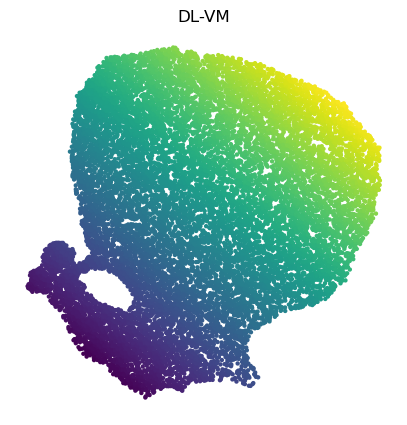

In [22]:
define_axis(s50_right_str, rotate_axis=40, n_bins=300, bin_name='DL-VM')
mouse_corr = correlate_with_axis(s50_right_str, axis_name='DL-VM')

In [23]:
mouse_corr

gene  correlation
0            Sema7a     0.958538
1     C030013G03Rik     0.954191
2           Gm26645     0.945788
3             Cwh43     0.943880
4            Gm6556     0.939752
...             ...          ...
8443        Osbpl10    -0.947296
8444          Dpp10    -0.948683
8445            Ak5    -0.952847
8446          Cadm1    -0.953422
8447        Zcchc12    -0.955116

[8448 rows x 2 columns]

In [24]:
# Human DL-VM axis correlation is run on another computer and results are loaded in here.
zscored_expression = pd.read_csv('../../../../Data/Stereo-seq_human_bg/DL-VM_axis/chip34_VMDL_binned_expression.csv')
# Remove column
zscored_expression = zscored_expression.drop(columns=['Unnamed: 0'])
zscored_expression

5  5S_rRNA  5_8S_rRNA       7SK          A      A1BG  A1BG-AS1  \
0   NaN -0.11221   2.478145 -1.976590  -0.102586  0.676609 -0.655618   
1   NaN -0.11221   1.648123 -1.399677  -0.102586  1.164586 -0.655618   
2   NaN -0.11221   1.065499  0.434240  -0.102586  0.673981 -0.655618   
3   NaN -0.11221   0.555845 -0.384730  16.181131  3.499250 -0.655618   
4   NaN -0.11221   0.438454 -1.653041   0.578011  1.266940 -0.655618   
..   ..      ...        ...       ...        ...       ...       ...   
354 NaN -0.11221   4.359391 -2.229582  -0.102586 -1.391770  0.060761   
355 NaN -0.11221   3.894808 -2.229582  -0.102586 -1.925625 -0.655618   
356 NaN -0.11221   3.583157 -2.229582  -0.102586 -1.925625 -0.655618   
357 NaN -0.11221   2.917177 -2.229582  -0.102586 -1.925625 -0.655618   
358 NaN -0.11221   1.568299 -2.229582  -0.102586 -1.925625 -0.655618   

         A1CF       A2M   A2M-AS1  ...    ZYG11B       ZYX     ZYXP1  \
0   -0.320331 -0.385731 -0.382221  ...  0.053165 -1.197700 -0.446531   
1   -0.320331 -2.812686 -0.382221  ...  0.629368 -1.197700 -0.446531   
2   -0.320331 -2.383345 -0.382221  ...  1.381622 -1.197700 -0.446531   
3   -0.320331  1.254671 -0.382221  ... -0.523741  0.382239 -0.446531   
4   -0.320331 -0.054533 -0.382221  ... -1.847693 -0.316638 -0.372319   
..        ...       ...       ...  ...       ...       ...       ...   
354 -0.320331 -2.013275 -0.382221  ...  2.324002 -1.197700 -0.446531   
355 -0.320331 -2.971224 -0.382221  ... -0.160525 -1.197700 -0.446531   
356 -0.320331 -2.971224 -0.382221  ... -1.555819 -1.197700 -0.446531   
357 -0.320331 -2.971224 -0.382221  ... -1.787022 -1.197700 -0.446531   
358 -0.320331 -2.971224 -0.382221  ... -2.276890 -1.197700 -0.446531   

        ZZEF1      ZZZ3   h  hsa-mir-1253  hsa-mir-423  hsa-mir-8069-1  \
0   -1.759796 -1.211336 NaN           NaN          NaN       -0.697059   
1   -1.759796  3.581086 NaN           NaN          NaN       -0.697059   
2   -1.759796  8.812306 NaN           NaN          NaN        0.747792   
3   -1.479890  3.631212 NaN           NaN          NaN        3.798816   
4   -1.465658  0.466437 NaN           NaN          NaN        6.712792   
..        ...       ...  ..           ...          ...             ...   
354 -1.759796 -1.649428 NaN           NaN          NaN       -0.697059   
355 -1.759796 -1.649428 NaN           NaN          NaN       -0.697059   
356 -1.759796 -1.649428 NaN           NaN          NaN       -0.697059   
357 -1.759796 -1.649428 NaN           NaN          NaN       -0.697059   
358 -1.759796 -1.649428 NaN           NaN          NaN       -0.697059   

      snoZ196  
0   -0.123367  
1   -0.123367  
2   -0.123367  
3   -0.123367  
4   -0.123367  
..        ...  
354 -0.123367  
355 -0.123367  
356 -0.123367  
357 -0.123367  
358 -0.123367  

[359 rows x 36126 columns]

In [25]:
# Replace infinite values with NaN and drop columns with NaN values
zscored_expression = zscored_expression.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Bin indices serve as the digitized axis for correlation
bin_indices = zscored_expression.index.values
gene_correlations = []

import scipy.stats as stats
for gene in zscored_expression.columns:
    # pearsonr returns (correlation coefficient, p-value)
    corr, _ = stats.pearsonr(bin_indices, zscored_expression[gene].values)
    gene_correlations.append({'gene': gene, 'correlation': corr})

correlation_df = pd.DataFrame(gene_correlations)

# Drop genes with NaN correlation 
correlation_df = correlation_df.dropna(subset=['correlation'])

# Sort  DataFrame by correlation coefficient
correlation_df_sorted = correlation_df.sort_values(by='correlation', ascending=False)
human_corr = correlation_df_sorted.reset_index(drop=True)

human_corr

gene  correlation
0           NRGN     0.827242
1            MBP     0.809940
2         PDE10A     0.797078
3          RASD2     0.785627
4          GPR88     0.736504
...          ...          ...
29409      SYNPR    -0.859164
29410      HTR2C    -0.866466
29411       CRYM    -0.870337
29412  LINC03000    -0.874100
29413       NNAT    -0.889783

[29414 rows x 2 columns]

In [30]:
def common_genes(human_genes, mouse_genes, batch_size=200):
    human_genes = list(human_genes)
    mouse_genes = list(mouse_genes)
    from biomart import BiomartServer
    server = BiomartServer("http://www.ensembl.org/biomart")
    hsapiens = server.datasets['hsapiens_gene_ensembl']
    mapping = {}
    for i in range(0, len(human_genes), batch_size):
        batch = human_genes[i:i+batch_size]
        response = hsapiens.search({
            'attributes': [
                'external_gene_name',
                'mmusculus_homolog_associated_gene_name'
            ],
            'filters': {
                'external_gene_name': batch
            }
        })
        for row in response.iter_lines():
            h, m = row.decode().split('\t')
            if h and m and m in mouse_genes:
                mapping[h] = m
    return mapping

In [31]:
mapping = common_genes(human_corr['gene'], mouse_corr['gene'])

In [32]:
# Check for duplicate mouse genes (one mouse gene mapped to multiple human genes)
mouse_genes_list = list(mapping.values())
duplicate_mouse_genes = [gene for gene in set(mouse_genes_list) if mouse_genes_list.count(gene) > 1]

if duplicate_mouse_genes:
    print(f"Found {len(duplicate_mouse_genes)} mouse genes that map to multiple human genes (paralogs):")
    for mouse_gene in duplicate_mouse_genes:
        human_genes = [k for k, v in mapping.items() if v == mouse_gene]
        print(f"  {mouse_gene}: {human_genes}")
    
    # Filter out paralog mappings - keep only 1:1 ortholog mappings
    filtered_mapping = {k: v for k, v in mapping.items() if v not in duplicate_mouse_genes}
    print(f"\nOriginal mappings: {len(mapping)}")
    print(f"Filtered mappings (orthologs only): {len(filtered_mapping)}")
    
    # Update the mapping to use the filtered version
    mapping = filtered_mapping
else:
    print("No mouse genes map to multiple human genes - all mappings are 1:1 orthologs")

# Now filter correlation dataframes to only include ortholog genes
human_ortholog_genes = set(mapping.keys())
mouse_ortholog_genes = set(mapping.values())

# Filter to only include genes that have 1:1 orthologs
human_corr_filtered = human_corr[human_corr['gene'].isin(human_ortholog_genes)].copy()
mouse_corr_filtered = mouse_corr[mouse_corr['gene'].isin(mouse_ortholog_genes)].copy()

print(f"\nFiltered human genes: {len(human_corr_filtered)} (was {len(human_corr)})")
print(f"Filtered mouse genes: {len(mouse_corr_filtered)} (was {len(mouse_corr)})")

# Update dataframes to use the filtered versions
human_corr = human_corr_filtered
mouse_corr = mouse_corr_filtered

Found 59 mouse genes that map to multiple human genes (paralogs):
  Slfn9: ['SLFN13', 'SLFN11']
  Tnfrsf23: ['TNFRSF10B', 'TNFRSF10D', 'TNFRSF10C']
  Ramac: ['RAMACL', 'RAMAC']
  Mill2: ['MICB', 'MICA']
  Nudt4: ['NUDT4B', 'NUDT4']
  Xcl1: ['XCL1', 'XCL2']
  Nipsnap3b: ['NIPSNAP3A', 'NIPSNAP3B']
  Xlr3b: ['FAM9B', 'FAM9C']
  Ppp1r2: ['PPP1R2', 'PPP1R2B']
  Kcnj12: ['KCNJ18', 'KCNJ12']
  Lefty2: ['LEFTY2', 'LEFTY1']
  Rpe: ['RPEL1', 'RPE']
  Klre1: ['KLRC3', 'KLRC2', 'KLRC4']
  Siglecg: ['SIGLEC16', 'SIGLEC10', 'SIGLEC11']
  Pcdh11x: ['PCDH11Y', 'PCDH11X']
  Ckmt1: ['CKMT1A', 'CKMT1B']
  Srgap2: ['SRGAP2B', 'SRGAP2C', 'SRGAP2']
  Ccl4: ['CCL4', 'CCL4L2']
  Actr3b: ['ACTR3C', 'ACTR3B']
  Trbc2: ['TRBC1', 'TRBC2']
  Dhfr: ['DHFR', 'DHFR2']
  Bex1: ['BEX1', 'BEX2']
  Acot1: ['ACOT1', 'ACOT2']
  Sirpa: ['SIRPA', 'SIRPG']
  Glud1: ['GLUD2', 'GLUD1']
  Sult5a1: ['SULT1A1', 'SULT1A2', 'SULT1A4', 'SULT1A3']
  Smim10l2a: ['SMIM10L2A', 'SMIM10L2B']
  Chrna7: ['CHRNA7', 'CHRFAM7A']
  Washc2: ['WAS

In [33]:
human_corr

gene  correlation
0         NRGN     0.827242
1          MBP     0.809940
2       PDE10A     0.797078
3        RASD2     0.785627
4        GPR88     0.736504
...        ...          ...
29406  GALNTL6    -0.846023
29408    LSAMP    -0.851652
29409    SYNPR    -0.859164
29410    HTR2C    -0.866466
29411     CRYM    -0.870337

[6731 rows x 2 columns]

In [34]:
mouse_corr

gene  correlation
0      Sema7a     0.958538
3       Cwh43     0.943880
6        Tpm2     0.935240
7      Gpr139     0.934224
8       Robo3     0.931642
...       ...          ...
8442    Dchs2    -0.942510
8443  Osbpl10    -0.947296
8444    Dpp10    -0.948683
8445      Ak5    -0.952847
8446    Cadm1    -0.953422

[6731 rows x 2 columns]

# Heatmaps

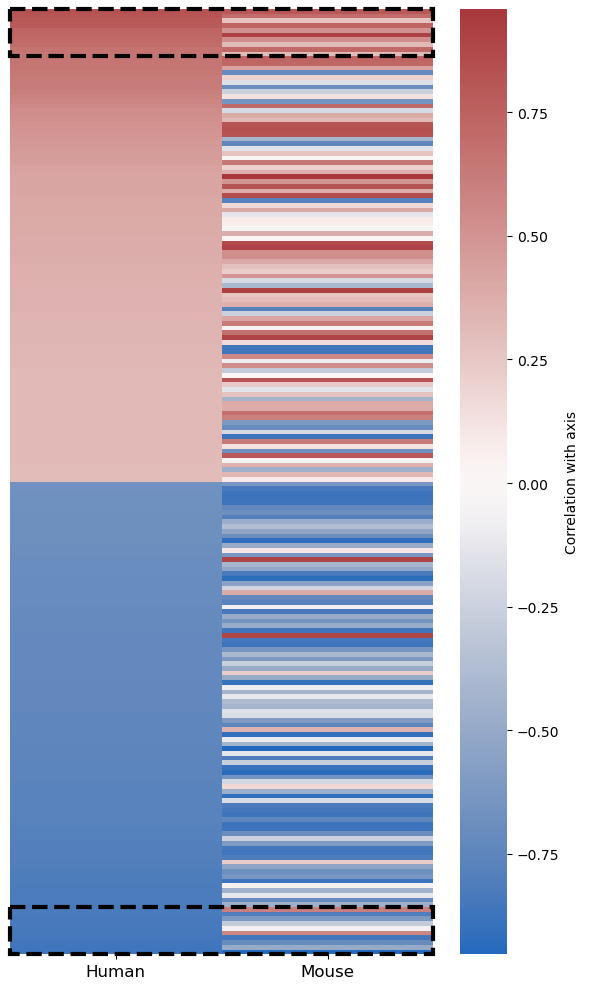

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Parameters
n_genes = 100
save_path = '../images/DL-VM_heatmap_ortholog_200genes.png'
show_gene_labels = False  # set True to show row labels

human_corr_idx = human_corr.set_index('gene')['correlation']
mouse_corr_idx = mouse_corr.set_index('gene')['correlation']

# Keep only mapping pairs present in both correlation tables
valid_pairs = [
    (h_gene, mapping[h_gene])
    for h_gene in mapping
    if h_gene in human_corr_idx.index and mapping[h_gene] in mouse_corr_idx.index
]

orth_df = pd.DataFrame({
    'Human_gene': [h for h, m in valid_pairs],
    'Mouse_gene': [m for h, m in valid_pairs],
    'Human_corr': [human_corr_idx[h] for h, m in valid_pairs],
    'Mouse_corr': [mouse_corr_idx[m] for h, m in valid_pairs],
})

# Select top & bottom by human correlation
top = orth_df.nlargest(n_genes, 'Human_corr')
bottom = orth_df.nsmallest(n_genes, 'Human_corr')
sel = pd.concat([top, bottom])

# Order rows (descending human correlation)
sel = sel.sort_values('Human_corr', ascending=False)

plot_df = sel[['Human_corr', 'Mouse_corr']].rename(columns={
    'Human_corr': 'Human',
    'Mouse_corr': 'Mouse'
})
plot_df.index = sel['Human_gene']

plt.figure(figsize=(6, 10))
ax = sns.heatmap(
    plot_df,
    cmap='vlag',
    center=0,
    cbar_kws={'label': 'Correlation with axis'},
    yticklabels=plot_df.index if show_gene_labels else False
)
ax.set_xlabel('')
ax.set_ylabel('')
if show_gene_labels:
    ax.tick_params(axis='y', labelsize=6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

highlight_n = 10
# Top block
ax.add_patch(patches.Rectangle(
    (0, 0),
    plot_df.shape[1],
    highlight_n,
    linewidth=3,
    edgecolor='black',
    facecolor='none',
    linestyle='--',
    clip_on=False
))
# Bottom block
bottom_start = plot_df.shape[0] - highlight_n
ax.add_patch(patches.Rectangle(
    (0, bottom_start),
    plot_df.shape[1],
    highlight_n,
    linewidth=3,
    edgecolor='black',
    facecolor='none',
    linestyle='--',
    clip_on=False
))

plt.tight_layout()
if save_path:
    plt.savefig(fname=save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [41]:
from scipy.stats import pearsonr, spearmanr

N = 50

# Build aligned ortholog correlation table
h_idx = human_corr.set_index('gene')['correlation']
m_idx = mouse_corr.set_index('gene')['correlation']
pairs = [
    (h, mapping[h])
    for h in mapping
    if h in h_idx.index and mapping[h] in m_idx.index
]
orth = pd.DataFrame({
    'human_gene': [h for h, m in pairs],
    'mouse_gene': [m for h, m in pairs],
    'human_corr': [h_idx[h] for h, m in pairs],
    'mouse_corr': [m_idx[m] for h, m in pairs],
})

# Select top & bottom by human correlation
top = orth.nlargest(min(N, orth.shape[0]), 'human_corr').copy()
bottom = orth.nsmallest(min(N, orth.shape[0]), 'human_corr').copy()

df = pd.concat([top, bottom])

r_p = pearsonr(df['human_corr'], df['mouse_corr'])
print(r_p)

PearsonRResult(statistic=np.float64(0.6686679243434905), pvalue=np.float64(2.90956650079613e-14))


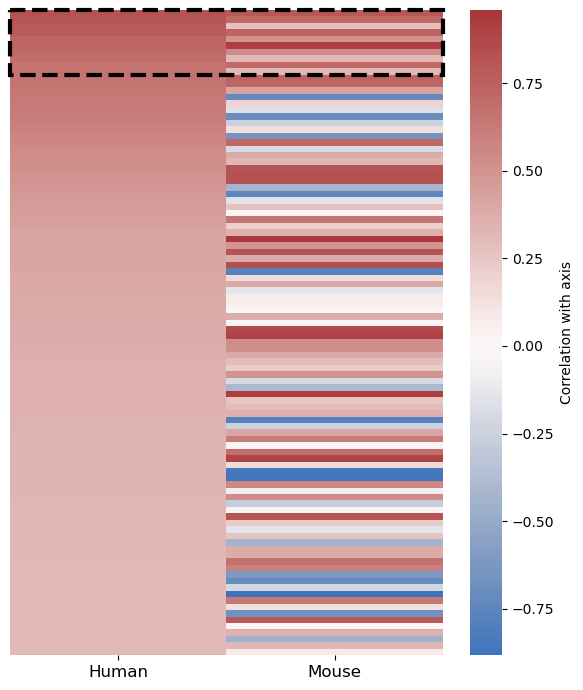

In [42]:
# Parameters
n_genes = 100
save_path = '../images/DL-VM_heatmap_top100genes.png'
show_gene_labels = False  # set True to show row labels

# Requires: human_corr, mouse_corr (already filtered to orthologs) and mapping {human_gene -> mouse_gene}
human_corr_idx = human_corr.set_index('gene')['correlation']
mouse_corr_idx = mouse_corr.set_index('gene')['correlation']

# Build ortholog pairs present in both correlation tables
valid_pairs = [
    (h_gene, mapping[h_gene])
    for h_gene in mapping
    if (h_gene in human_corr_idx.index) and (mapping[h_gene] in mouse_corr_idx.index)
]

if not valid_pairs:
    raise ValueError("No valid human–mouse ortholog pairs found for plotting.")

orth_df = pd.DataFrame({
    'Human_gene': [h for h, m in valid_pairs],
    'Mouse_gene': [m for h, m in valid_pairs],
    'Human_corr': [human_corr_idx[h] for h, m in valid_pairs],
    'Mouse_corr': [mouse_corr_idx[m] for h, m in valid_pairs],
})

# Select top N by human correlation
sel = orth_df.nlargest(n_genes, 'Human_corr').copy()
sel = sel.sort_values('Human_corr', ascending=False)

plot_df = sel[['Human_corr', 'Mouse_corr']].rename(columns={
    'Human_corr': 'Human',
    'Mouse_corr': 'Mouse'
})
plot_df.index = sel['Human_gene']

plt.figure(figsize=(6, 7))
ax = sns.heatmap(
    plot_df,
    cmap='vlag',
    center=0,
    cbar_kws={'label': 'Correlation with axis'},
    yticklabels=plot_df.index if show_gene_labels else False,
    xticklabels=True
)
ax.set_xlabel('')
ax.set_ylabel('')
if show_gene_labels:
    ax.tick_params(axis='y', labelsize=6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# Highlight top 10 rows
highlight_n = min(10, plot_df.shape[0])
ax.add_patch(patches.Rectangle(
    (0, 0),
    plot_df.shape[1],
    highlight_n,
    linewidth=3,
    edgecolor='black',
    facecolor='none',
    linestyle='--',
    clip_on=False
))

plt.tight_layout()
if save_path:
    plt.savefig(fname=save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

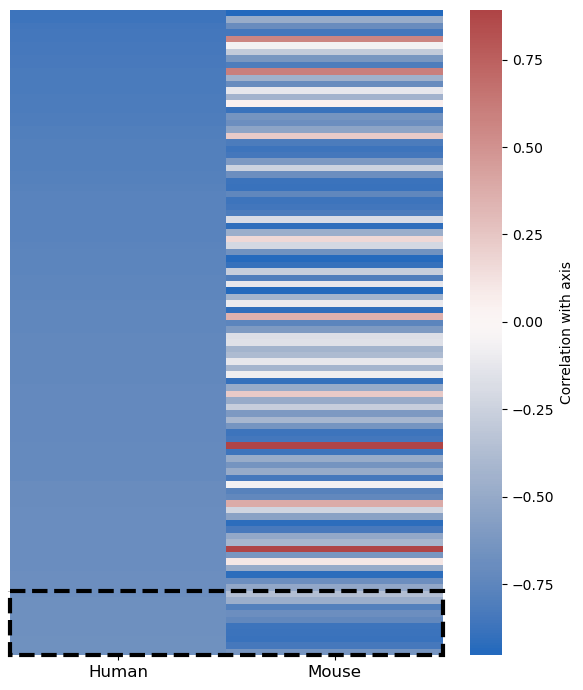

In [43]:
# Parameters
n_genes = 100
save_path = '../images/DL-VM_heatmap_bottom100genes.png'
show_gene_labels = False  # set True for row labels

# Requires: human_corr, mouse_corr filtered to orthologs; mapping {human_gene -> mouse_gene}
human_corr_idx = human_corr.set_index('gene')['correlation']
mouse_corr_idx = mouse_corr.set_index('gene')['correlation']

# Build ortholog pairs present in both correlation tables
valid_pairs = [
    (h_gene, mapping[h_gene])
    for h_gene in mapping
    if (h_gene in human_corr_idx.index) and (mapping[h_gene] in mouse_corr_idx.index)
]

if not valid_pairs:
    raise ValueError("No valid human–mouse ortholog pairs found for plotting.")

orth_df = pd.DataFrame({
    'Human_gene': [h for h, m in valid_pairs],
    'Mouse_gene': [m for h, m in valid_pairs],
    'Human_corr': [human_corr_idx[h] for h, m in valid_pairs],
    'Mouse_corr': [mouse_corr_idx[m] for h, m in valid_pairs],
})

# Select bottom N by human correlation
sel = orth_df.nsmallest(n_genes, 'Human_corr').copy()
# Order
sel = sel.sort_values('Human_corr', ascending=True)

plot_df = sel[['Human_corr', 'Mouse_corr']].rename(columns={
    'Human_corr': 'Human',
    'Mouse_corr': 'Mouse'
})
plot_df.index = sel['Human_gene']

plt.figure(figsize=(6, 7))
ax = sns.heatmap(
    plot_df,
    cmap='vlag',
    center=0,
    cbar_kws={'label': 'Correlation with axis'},
    yticklabels=plot_df.index if show_gene_labels else False,
    xticklabels=True
)
ax.set_xlabel('')
ax.set_ylabel('')
if show_gene_labels:
    ax.tick_params(axis='y', labelsize=6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=12)

# Highlight bottom 10 rows
highlight_n = min(10, plot_df.shape[0])
bottom_start = plot_df.shape[0] - highlight_n
ax.add_patch(patches.Rectangle(
    (0, bottom_start),
    plot_df.shape[1],
    highlight_n,
    linewidth=3,
    edgecolor='black',
    facecolor='none',
    linestyle='--',
    clip_on=False
))

plt.tight_layout()
if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

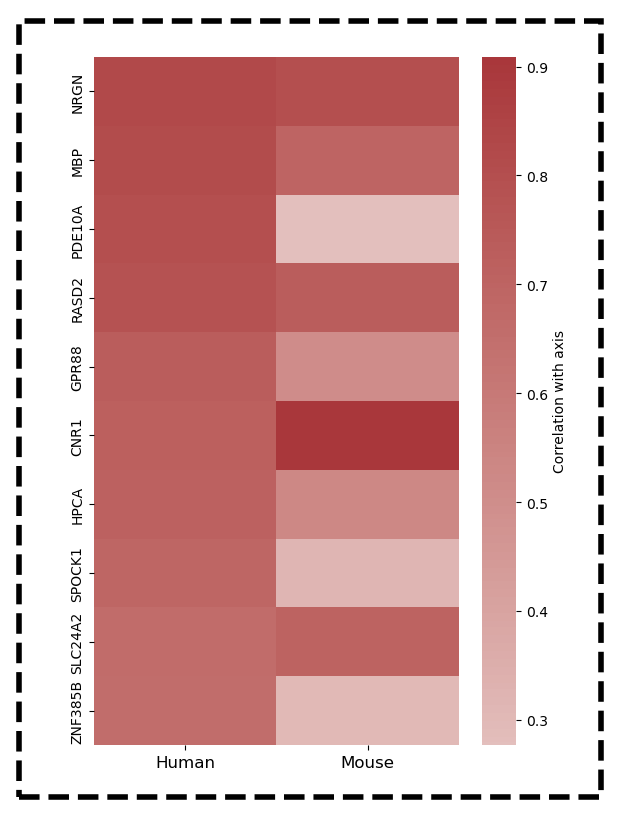

In [45]:
# Parameters
n_genes = 10
show_gene_labels = True
save_path = '../images/DL-VM_heatmap_top10genes.png'

# Requires: human_corr, mouse_corr filtered; mapping {human_gene -> mouse_gene}
human_corr_idx = human_corr.set_index('gene')['correlation']
mouse_corr_idx = mouse_corr.set_index('gene')['correlation']

# Valid ortholog pairs present in both datasets
valid_pairs = [
    (h_gene, mapping[h_gene])
    for h_gene in mapping
    if (h_gene in human_corr_idx.index) and (mapping[h_gene] in mouse_corr_idx.index)
]

if not valid_pairs:
    raise ValueError("No valid ortholog pairs for plotting.")

orth_df = pd.DataFrame({
    'Human_gene': [h for h, m in valid_pairs],
    'Mouse_gene': [m for h, m in valid_pairs],
    'Human_corr': [human_corr_idx[h] for h, m in valid_pairs],
    'Mouse_corr': [mouse_corr_idx[m] for h, m in valid_pairs],
})

# Top N by human correlation
sel = orth_df.nlargest(n_genes, 'Human_corr').copy()
sel = sel.sort_values('Human_corr', ascending=False)

plot_df = sel[['Human_corr', 'Mouse_corr']].rename(columns={
    'Human_corr': 'Human',
    'Mouse_corr': 'Mouse'
})
plot_df.index = sel['Human_gene']

# Figure with outer dotted border
fig = plt.figure(figsize=(6, 8))

outer = fig.add_axes([0, 0, 1, 1])
outer.set_axis_off()
outer.set_xlim(0, 1); outer.set_ylim(0, 1)
margin = 0.015
outer.add_patch(
    patches.Rectangle(
        (margin, margin),
        1 - 2*margin,
        1 - 2*margin,
        linewidth=4,
        linestyle='--',
        edgecolor='black',
        facecolor='none',
        transform=outer.transAxes
    )
)

ax = fig.add_axes([0.14, 0.08, 0.76, 0.86])
sns.heatmap(
    plot_df,
    cmap='vlag',
    center=0,
    cbar_kws={'label': 'Correlation with axis'},
    yticklabels=plot_df.index if show_gene_labels else False,
    xticklabels=True,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('')
if show_gene_labels:
    ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=12)

if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

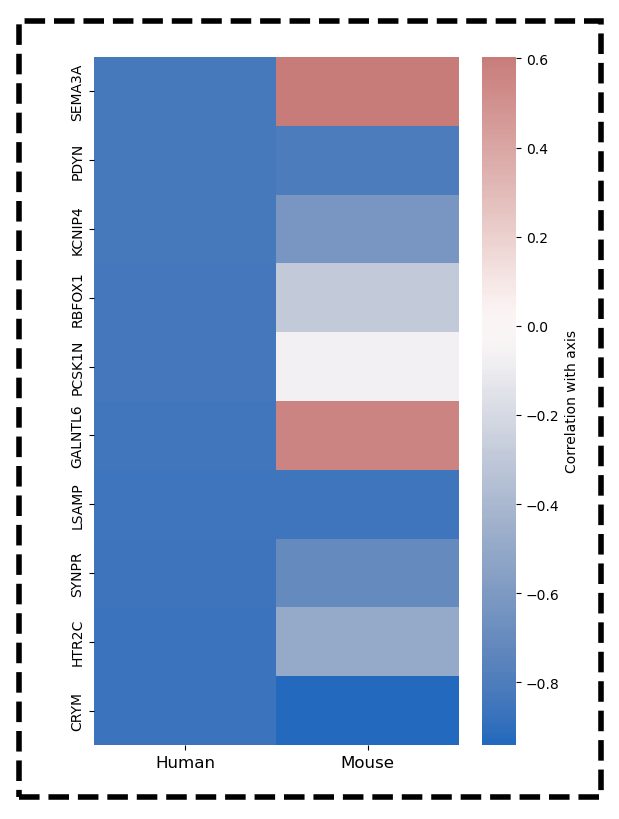

In [46]:
# Parameters
n_genes = 10
show_gene_labels = True
save_path = '../images/DL-VM_heatmap_bottom10genes.png'

# Mapping-based (requires human_corr, mouse_corr already filtered; mapping {human_gene -> mouse_gene})
human_corr_idx = human_corr.set_index('gene')['correlation']
mouse_corr_idx = mouse_corr.set_index('gene')['correlation']

valid_pairs = [
    (h_gene, mapping[h_gene])
    for h_gene in mapping
    if (h_gene in human_corr_idx.index) and (mapping[h_gene] in mouse_corr_idx.index)
]
if not valid_pairs:
    raise ValueError("No valid ortholog pairs for plotting.")

orth_df = pd.DataFrame({
    'Human_gene': [h for h, m in valid_pairs],
    'Mouse_gene': [m for h, m in valid_pairs],
    'Human_corr': [human_corr_idx[h] for h, m in valid_pairs],
    'Mouse_corr': [mouse_corr_idx[m] for h, m in valid_pairs],
})

# Bottom N by human correlation (most negative)
sel = orth_df.nsmallest(n_genes, 'Human_corr').copy()
sel = sel.sort_values('Human_corr', ascending=False)

plot_df = sel[['Human_corr', 'Mouse_corr']].rename(columns={
    'Human_corr': 'Human',
    'Mouse_corr': 'Mouse'
})
plot_df.index = sel['Human_gene']

# Figure with outer dotted border
fig = plt.figure(figsize=(6, 8))
outer = fig.add_axes([0, 0, 1, 1])
outer.set_axis_off()
outer.set_xlim(0, 1); outer.set_ylim(0, 1)
margin = 0.015
outer.add_patch(
    patches.Rectangle(
        (margin, margin),
        1 - 2*margin,
        1 - 2*margin,
        linewidth=4,
        linestyle='--',
        edgecolor='black',
        facecolor='none',
        transform=outer.transAxes
    )
)

# Inner heatmap axes
ax = fig.add_axes([0.14, 0.08, 0.76, 0.86])
sns.heatmap(
    plot_df,
    cmap='vlag',
    center=0,
    cbar_kws={'label': 'Correlation with axis'},
    yticklabels=plot_df.index if show_gene_labels else False,
    xticklabels=True,
    ax=ax
)
ax.set_xlabel('')
ax.set_ylabel('')
if show_gene_labels:
    ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='x', labelsize=12)

if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Spatial expression plots

In [47]:
def plot_gene_compare(
    adata1,
    adata2,
    human_gene,
    spatials=("spatial", "X_spatial"),
    cmap="vlag",
    size_range=(5, 25),
    vmax1=None,
    vmax2=None,
    colorbar=True,
    save_path=None,
    dpi=300
):
    """
    Compare spatial expression of a human gene and its mouse ortholog.
    Simplified:
      - No shared scaling logic
      - No vmin argument (each plot uses its own min)
      - Independent vmax per dataset (vmax1, vmax2). If None, use data max.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    def _get_expr(adata, g):
        if g not in adata.var_names:
            raise ValueError(f"Gene '{g}' not found.")
        x = adata[:, g].X
        if hasattr(x, "toarray"):
            x = x.toarray().ravel()
        else:
            x = np.asarray(x).ravel()
        return x

    expr1 = _get_expr(adata1, human_gene)
    mouse_gene = mapping.get(human_gene)
    if mouse_gene is None:
        raise ValueError(f"No mouse ortholog found for '{human_gene}'.")
    expr2 = _get_expr(adata2, mouse_gene)

    vmin1, vmin2 = expr1.min(), expr2.min()
    vmax1 = expr1.max() if vmax1 is None else vmax1
    vmax2 = expr2.max() if vmax2 is None else vmax2

    coords1 = adata1.obsm[spatials[0]][:, :2]
    coords2 = adata2.obsm[spatials[1]][:, :2]

    def _sizes(expr, smin, smax, vmax_local):
        if vmax_local <= 0:
            return np.full(expr.shape, smin, float)
        return np.clip(smin + (smax - smin) * (expr / vmax_local), smin, smax)

    s1 = _sizes(expr1, size_range[0], size_range[1], vmax1)
    s2 = _sizes(expr2, size_range[0], size_range[1], vmax2)

    fig, axes = plt.subplots(3, 1, figsize=(4, 8), gridspec_kw={"height_ratios": [0.18, 1, 1]})

    axes[0].axis("off")
    axes[0].text(0.5, 0.5, human_gene, ha="center", va="center", fontsize=40, weight='bold')

    def _plot(ax, coords, expr, sizes, vmin_local, vmax_local):
        order = np.argsort(expr)
        sc = ax.scatter(
            coords[order, 0],
            coords[order, 1],
            c=expr[order],
            s=sizes[order],
            cmap=cmap,
            vmin=vmin_local,
            vmax=vmax_local,
            marker='.',
            linewidths=0
        )
        ax.axis("off")
        ax.set_aspect("equal")
        return sc

    sc1 = _plot(axes[1], coords1, expr1, s1, vmin1, vmax1)
    sc2 = _plot(axes[2], coords2, expr2, s2, vmin2, vmax2)

    if colorbar:
        fig.colorbar(sc1, ax=axes[1], fraction=0.046, pad=0.01).set_label("Expression", fontsize=9)
        fig.colorbar(sc2, ax=axes[2], fraction=0.046, pad=0.01).set_label("Expression", fontsize=9)

    plt.tight_layout()

    if save_path:
        os.makedirs(save_path, exist_ok=True)
        fig.savefig(
            os.path.join(save_path, f"{human_gene}_compare.png"),
            dpi=dpi,
            bbox_inches="tight",
            transparent=True
        )

    plt.show()
    return fig, axes

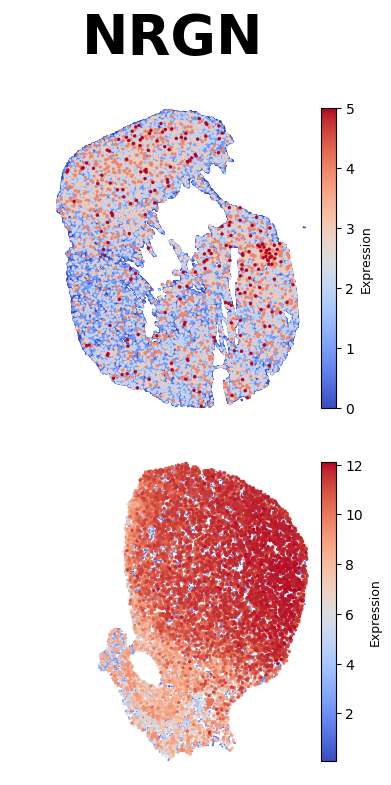

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [49]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='NRGN',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=5,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

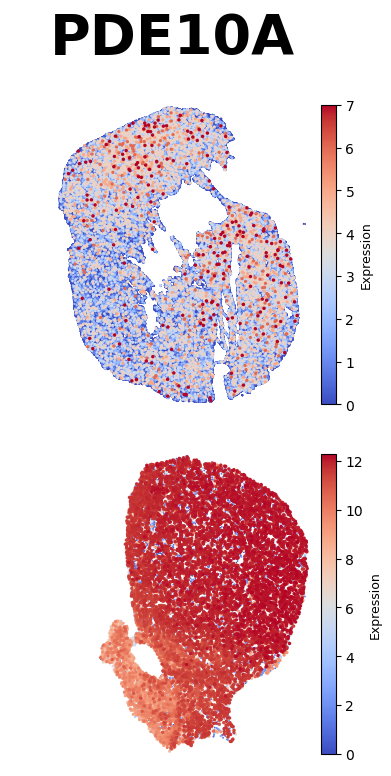

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [50]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='PDE10A',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=7,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

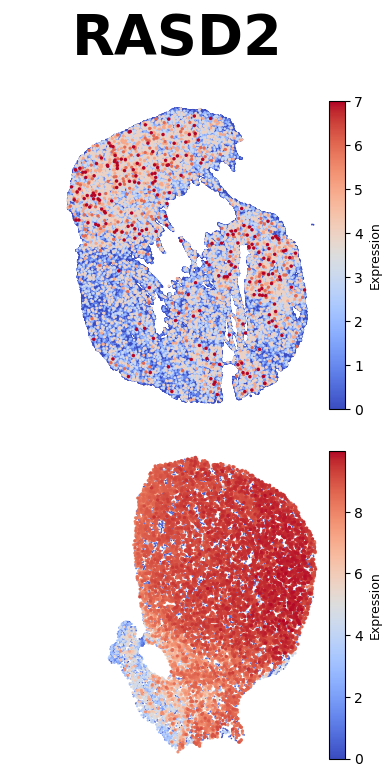

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [52]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='RASD2',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=7,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

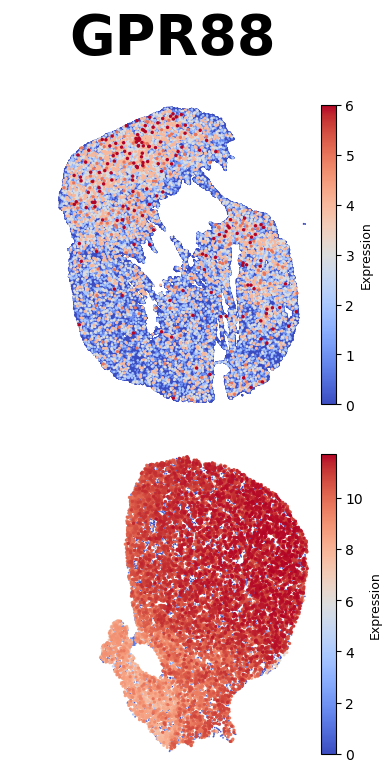

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [53]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='GPR88',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=6,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

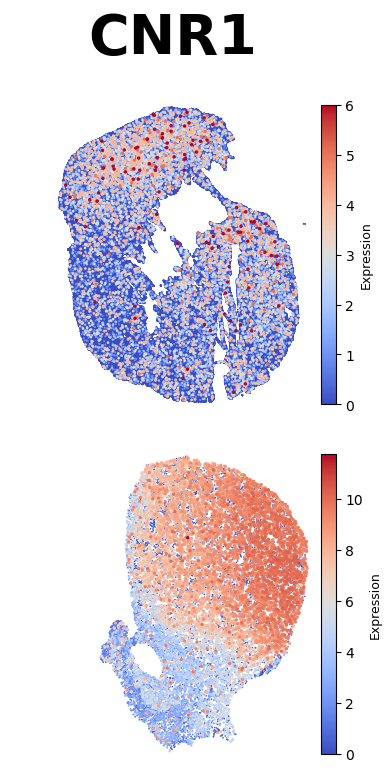

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [54]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='CNR1',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=6,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

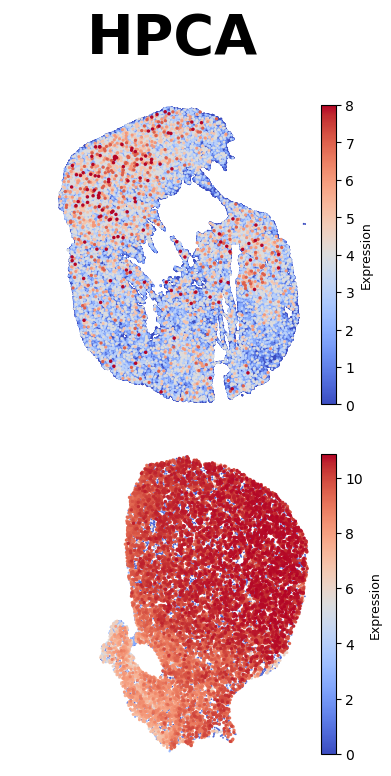

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [55]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='HPCA',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=8,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

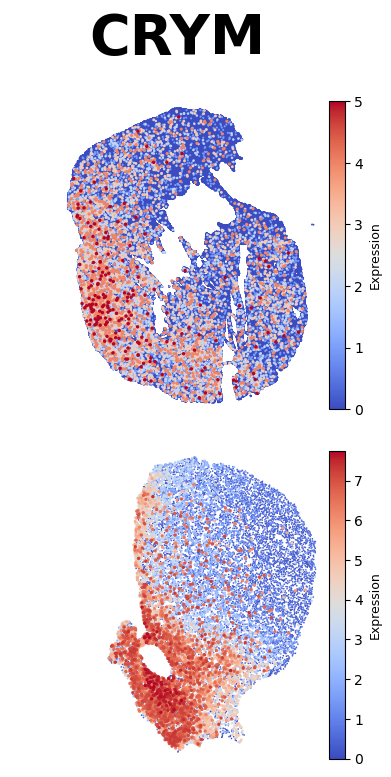

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [56]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='CRYM',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=5,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

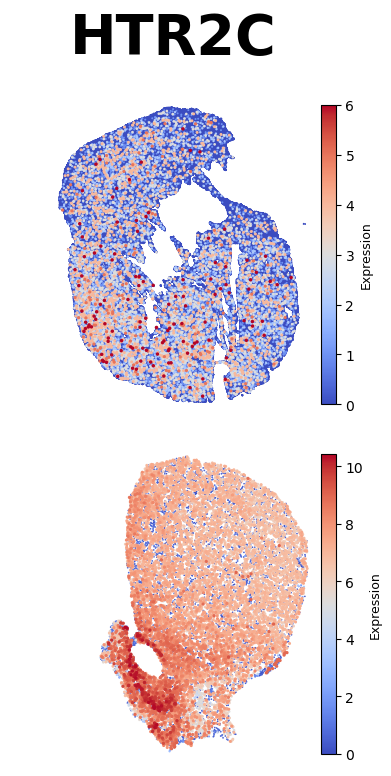

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [57]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='HTR2C',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=6,
    vmax2=None,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

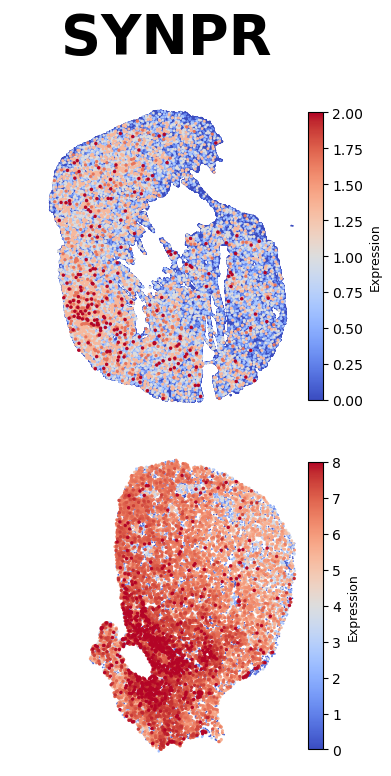

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [58]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='SYNPR',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=2,
    vmax2=8,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

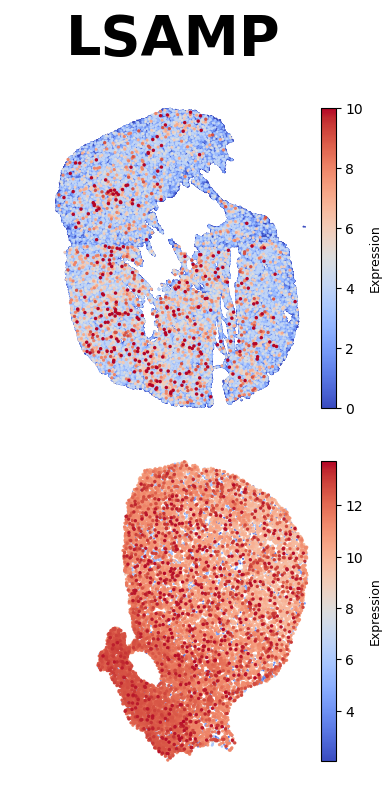

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [59]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='LSAMP',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=10,
    vmax2=None,
    colorbar=True,
    save_path=None,
    dpi=300
)

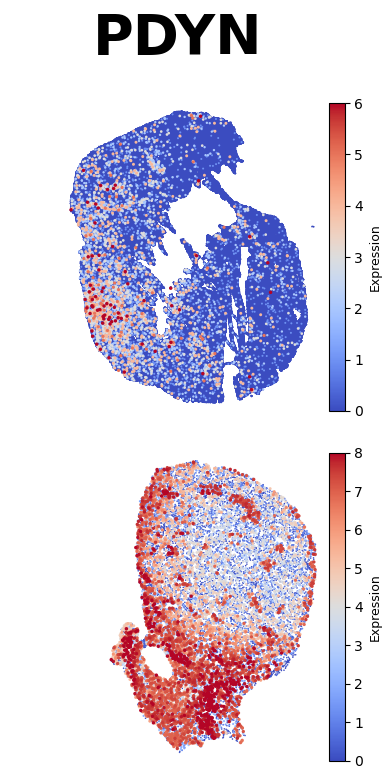

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [60]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='PDYN',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=6,
    vmax2=8,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

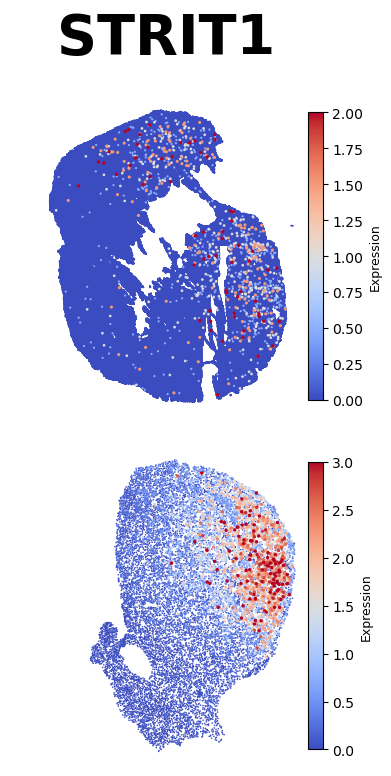

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [61]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='STRIT1',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=2,
    vmax2=3,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

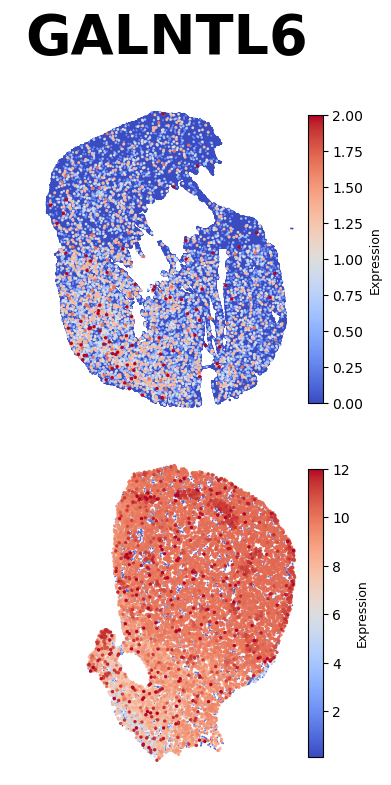

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [62]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='GALNTL6',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=2,
    vmax2=12,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

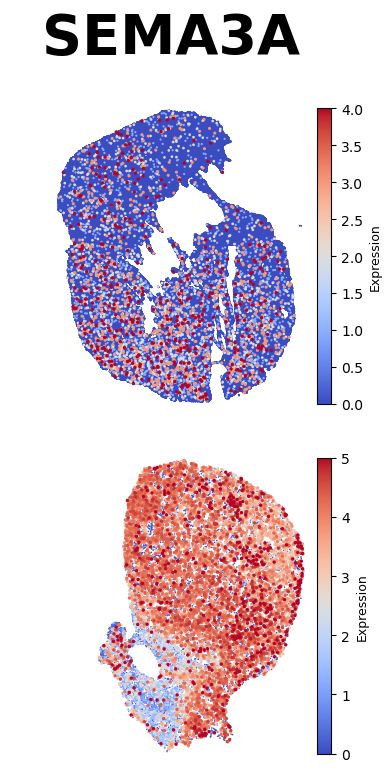

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [63]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='SEMA3A',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=4,
    vmax2=5,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

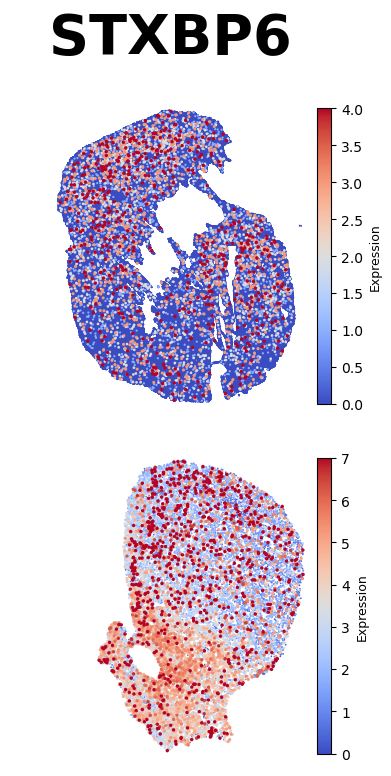

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [64]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='STXBP6',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=4,
    vmax2=7,
    colorbar=True,
    save_path='../images/',
    dpi=300
)

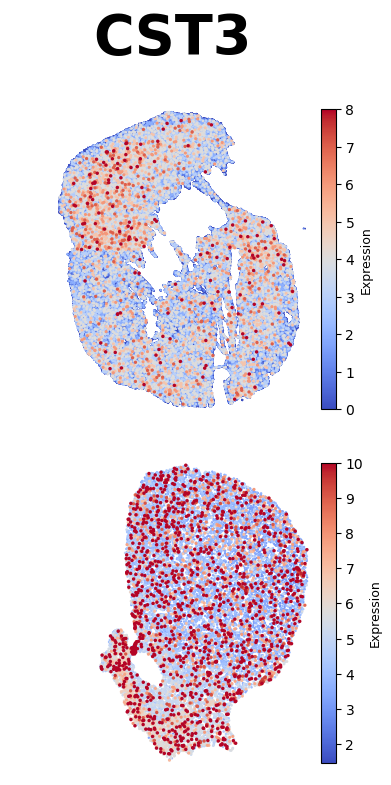

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [65]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='CST3',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=8,
    vmax2=10,
    colorbar=True,
    save_path=None,
    dpi=300
)

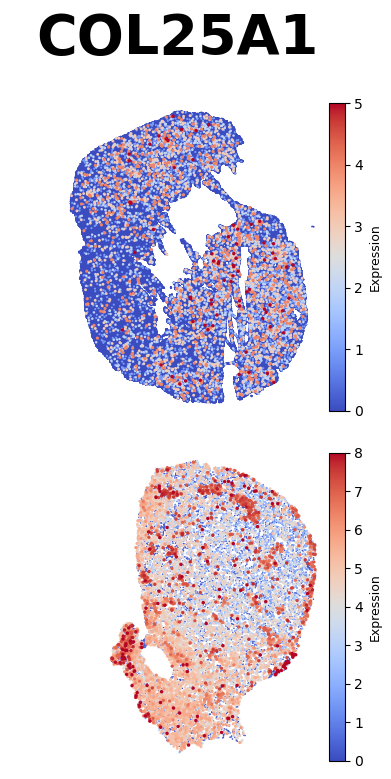

(<Figure size 400x800 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >], dtype=object))

In [66]:
plot_gene_compare(
    chip34,
    s50_right_str,
    human_gene='COL25A1',
    spatials=('spatial', 'X_spatial'),
    cmap='coolwarm',
    size_range=(5, 25),
    vmax1=5,
    vmax2=8,
    colorbar=True,
    save_path='../images/',
    dpi=300
)